In [77]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

from tqdm import tqdm
import logging
import sys
sys.path.append('../utils')
from utils import get_logger, Clock, frozenset_converter
from IPython.display import clear_output

In [78]:
logger = logging.getLogger(__name__)
logger = get_logger(logger=logger)

In [79]:
#filepath = 'C:\\Users\\User\\Documents\\jupyter_notebooks\\ufmg\\itemset_mining_applied_to_pokemon_teams\\'
filepath = '/home/gilliard/msi_ii/itemset_mining_applied_to_pokemon_teams/'
#teams_df = pd.read_csv(filepath + 'data\\processed\\ladder_teams.csv')
teams_df = pd.read_csv(filepath + 'data/processed/ladder_teams.csv')
logger.info(f"O dataframe resultante contém {teams_df.shape[0]} equipes.")

2023-10-31 16:44:47,983 - INFO - O dataframe resultante contém 11501 equipes.
2023-10-31 16:44:47,983 - INFO - O dataframe resultante contém 11501 equipes.
2023-10-31 16:44:47,983 - INFO - O dataframe resultante contém 11501 equipes.


In [80]:
pokemons = teams_df.stack().reset_index(drop=True)
unique_pokemons = pokemons.unique()

logger.info(f'Existem {len(unique_pokemons)} pokémons diferentes no dataset!')

2023-10-31 16:44:48,000 - INFO - Existem 392 pokémons diferentes no dataset!
2023-10-31 16:44:48,000 - INFO - Existem 392 pokémons diferentes no dataset!
2023-10-31 16:44:48,000 - INFO - Existem 392 pokémons diferentes no dataset!


In [81]:
print(teams_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11501 entries, 0 to 11500
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pokemon_1  11501 non-null  object
 1   pokemon_2  11501 non-null  object
 2   pokemon_3  11501 non-null  object
 3   pokemon_4  11501 non-null  object
 4   pokemon_5  11501 non-null  object
 5   pokemon_6  11501 non-null  object
dtypes: object(6)
memory usage: 539.2+ KB
None


Como podemos ver, não existem valores nulos no dataset!

/home/gilliard/miniconda3/envs/msi_env/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/gilliard/miniconda3/envs/msi_env/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



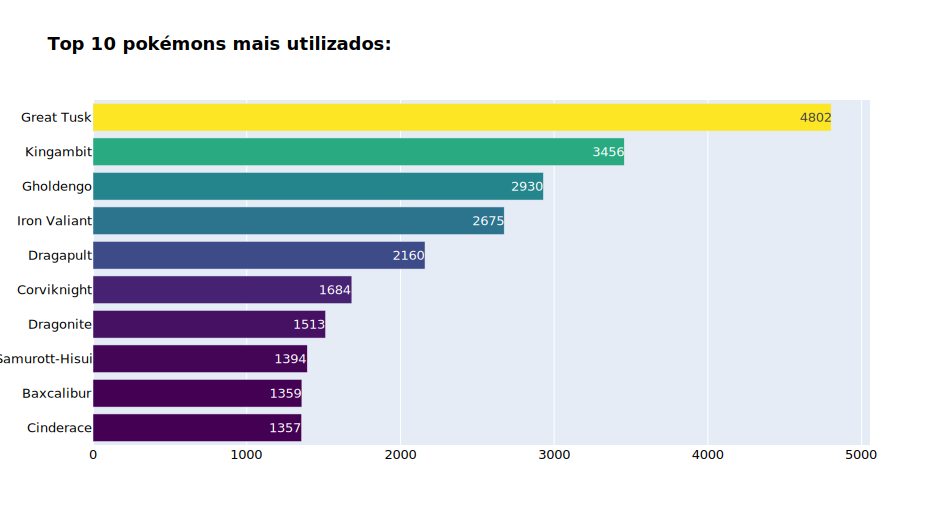

In [82]:
top10_most_used = pokemons.value_counts()[:10].sort_values()

fig = go.Figure(go.Bar(
            y=top10_most_used.index,
            x=top10_most_used.values,
            orientation='h',
            marker=dict(color = top10_most_used, colorscale='viridis'),
            hovertemplate='Usado %{x} vezes<extra></extra>',
            text=top10_most_used.values,
            textposition='auto'))
fig.update_layout(width=950,
                  height=525,
                  title_text="<b>Top 10 pokémons mais utilizados:<b>",
                  font_family="Century Gothic Medium",
                  font_color="black",
                  title_font_family="Century Gothic",
                  font_size=13)

fig.show(renderer="svg")

Ao que parece, _Great Tusk_, _Kingambit_ e _Gholdengo_ são os pokémons mais populares dessa _tier_. É interessante notar que dos pokémons que dominavam o pódio de popularidade na _tier OU gen8_ (_Landorus-Therian_, _Dragapult_ e _Clefable_), apenas o _Dragapult_ permanece.

Vamos fazer os imports necessários para a mineração de padrões frequentes:

In [83]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

Vamos converter o dataset de equipes para o formato que o algoritmo _fpgrowth_ espera como entrada:

In [84]:
tr_encoder = TransactionEncoder()
tr_encoder = tr_encoder.fit(teams_df.values)
tr_arr = tr_encoder.transform(teams_df.values)
tr_arr = tr_arr

In [85]:
tr_team_df = pd.DataFrame(tr_arr, columns=tr_encoder.columns_)
tr_team_df.head()

,Abomasnow,Alomomola,Altaria,Ambipom,Amoonguss,Ampharos,Annihilape,Appletun,Arboliva,Arcanine,...,Yanmega,Zamazenta-*,Zangoose,Zapdos,Zapdos-Galar,Zarude,Zarude-Dada,Zoroark,Zoroark-Hisui,Zorua
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Vamos aplicar o algoritmo _fpgrowth_ nos dados com vários valores de _min_support_ para visualizar quais são os itemsets frequentes para cada suporte:

In [86]:
supports = [0.2, 0.1, 0.05, 0.01]
logger.info("A iteração começará agora...")
iteration_time = Clock("Cálculo dos itemsets frequentes para 20, 10, 5 e 1%")
for support in supports:
    freq_itemsets = fpgrowth(tr_team_df, min_support=support, use_colnames=True)
    freq_itemsets = freq_itemsets.sort_values(by='support', ascending=False).reset_index(drop=True)
    freq_itemsets['support'] = [str(round(support * 100, 2)) + '%' for support in freq_itemsets['support']]
    print(f"Com {round(support * 100, 2)}% de suporte:")
    display(freq_itemsets)
    print("---------------------")
iteration_time.stop_watch()

2023-10-31 16:44:48,679 - INFO - A iteração começará agora...
2023-10-31 16:44:48,679 - INFO - A iteração começará agora...
2023-10-31 16:44:48,679 - INFO - A iteração começará agora...


Com 20.0% de suporte:


,support,itemsets
0,41.75%,(Great Tusk)
1,30.05%,(Kingambit)
2,25.47%,(Gholdengo)
3,23.26%,(Iron Valiant)


---------------------
Com 10.0% de suporte:


,support,itemsets
0,41.75%,(Great Tusk)
1,30.05%,(Kingambit)
2,25.47%,(Gholdengo)
3,23.26%,(Iron Valiant)
4,18.78%,(Dragapult)
5,14.64%,(Corviknight)
6,13.16%,(Dragonite)
7,12.34%,"(Kingambit, Great Tusk)"
8,12.12%,(Samurott-Hisui)
9,12.1%,"(Great Tusk, Gholdengo)"


---------------------
Com 5.0% de suporte:


,support,itemsets
0,41.75%,(Great Tusk)
1,30.05%,(Kingambit)
2,25.47%,(Gholdengo)
3,23.26%,(Iron Valiant)
4,18.78%,(Dragapult)
5,14.64%,(Corviknight)
6,13.16%,(Dragonite)
7,12.34%,"(Kingambit, Great Tusk)"
8,12.12%,(Samurott-Hisui)
9,12.1%,"(Great Tusk, Gholdengo)"


---------------------
Com 1.0% de suporte:


,support,itemsets
0,41.75%,(Great Tusk)
1,30.05%,(Kingambit)
2,25.47%,(Gholdengo)
3,23.26%,(Iron Valiant)
4,18.78%,(Dragapult)
...,...,...
573,1.01%,"(Zapdos, Landorus-Therian)"
574,1.01%,"(Ogerpon-Wellspring, Gholdengo)"
575,1.01%,"(Garganacl, Great Tusk, Toxapex)"
576,1.01%,"(Rotom-Wash, Slowking-Galar)"


2023-10-31 16:44:49,020 - INFO - Cálculo dos itemsets frequentes para 20, 10, 5 e 1% levou 00s para ser executado.


---------------------


O itemset mais frequente possui suporte relativo de 41.75% e trata-se de apenas um pokémon, _Great Tusk_, o que não é nenhuma surpresa dado que o gráfico de barras horizontes no início desse notebook já nos mostrava isso.

Pelo que podemos ver, para um suporte acima de 12.34%, já não existe mais itemsets frequentes com mais de um pokémon. Portanto, para explorarmos pokémons que aparecem juntos, teremos que testar suportes bem pequenos.

Pensando em regras de associação do formato X -> Y, vamos relembrar os conceitos de algumas métricas:
- Confidence: expressa a chance do pokémon Y ser escolhido para a equipe dado que o pokémon X foi escolhido.
- Lift: expressa a chance de Y ser escolhido, se X for escolhido, considerando toda a popularidade de Y.
    - Lift > 1: o pokémon Y é provável de ser escolhido quando X for escolhido.
    - Lift ≤ 1: NÃO é provável que Y seja escolhido, caso X seja escolhido.
- Leverage: mede a diferença entre a probabilidade conjunta observada e esperada de XY assumindo que X e Y são independentes. Deve ser avaliada junto com o Lift, já que um mesmo lift pode vir junto de diferentes valores de leverage.
- Conviction: calcula a frequência que X é escolhido e Y não, ou seja, ela está interessada em quando a regra falha. Um valor alto de convicção significa que o consequente é muito dependente do antecedente.

In [87]:
freq_itemsets = fpgrowth(tr_team_df.astype('bool'), min_support=0.01, use_colnames=True)
rules_df = association_rules(freq_itemsets, metric="lift", min_threshold=1)
rules_df = rules_df.sort_values(by='confidence', ascending=False).reset_index(drop=True)
rules_df["antecedent_len"] = rules_df["antecedents"].apply(lambda x: len(x))
rules_df["consequent_len"] = rules_df["consequents"].apply(lambda x: len(x))
rules_df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len,consequent_len
0,"(Ting-Lu, Toxapex, Alomomola)",(Blissey),0.010434,0.061125,0.010434,1.000000,16.359886,0.009796,inf,0.948774,3,1
1,"(Dondozo, Gliscor, Toxapex)",(Blissey),0.010695,0.061125,0.010695,1.000000,16.359886,0.010041,inf,0.949024,3,1
2,"(Dondozo, Ting-Lu, Alomomola)",(Blissey),0.011043,0.061125,0.011043,1.000000,16.359886,0.010368,inf,0.949358,3,1
3,"(Dondozo, Ting-Lu, Toxapex, Alomomola)",(Blissey),0.010347,0.061125,0.010347,1.000000,16.359886,0.009714,inf,0.948691,4,1
4,"(Great Tusk, Brute Bonnet)",(Torkoal),0.011825,0.055126,0.011738,0.992647,18.006993,0.011086,128.502913,0.955768,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1509,(Great Tusk),(Ogerpon-Hearthflame),0.417529,0.022172,0.010347,0.024781,1.117687,0.001089,1.002676,0.180773,1,1
1510,(Great Tusk),"(Gholdengo, Toxapex)",0.417529,0.013129,0.010260,0.024573,1.871624,0.004778,1.011732,0.799532,1,2
1511,(Great Tusk),"(Walking Wake, Brute Bonnet)",0.417529,0.010521,0.010260,0.024573,2.335662,0.005867,1.014406,0.981776,1,2
1512,(Great Tusk),"(Walking Wake, Torkoal, Brute Bonnet)",0.417529,0.010434,0.010173,0.024365,2.335168,0.005817,1.014279,0.981620,1,3


In [88]:
def is_team_complete(team: list) -> bool:
    return len(team) == 6
def has_suggestions(suggestions: pd.DataFrame) -> bool:
    return len(suggestions) > 0
def is_pokemon_weak_against(pokemon: pd.core.series.Series, type: str) -> bool:
    return pokemon[type] >= 2.0

def is_pokemon_strong_against(pokemon: pd.core.series.Series, type: str) -> bool:
    return pokemon[type] <= 0.5

def get_team_weaknesses(types: list, df: pd.DataFrame, team: list) -> set:
    team_effectiveness = {
        'strengths': set(), 
        'weaknesses': set()
    }
    for pokemon_name in team:
        pokemon = pokedex[pokedex['name'] == pokemon_name]
        for type in types:
            if is_pokemon_weak_against(pokemon, type).any():
                team_effectiveness['weaknesses'].add(type)
            elif is_pokemon_strong_against(pokemon, type).any():
                team_effectiveness['strengths'].add(type)
    team_weaknesses = team_effectiveness['weaknesses'] - team_effectiveness['strengths']
    return team_weaknesses 

def display_grouped_suggestions(suggestions: pd.DataFrame) -> pd.DataFrame:
    display(suggestions.groupby('Sugestão').agg({
                'Freq. utilizado com': lambda x: list(x),
                'Confiança': lambda x: list(x),
                'Lift': lambda x: list(x),
                'É um reforço contra': lambda x: list(x.unique())
            }).reset_index(names='Sugestão'))

def build_choice_advantage(team_weaknesses: list, suggestions: pd.DataFrame, col_name: str) -> pd.DataFrame:
    suggestions[col_name] = ''
    for suggestion in suggestions['consequents']:    
        name = list(suggestion)[0]
        pokemon = pokedex[pokedex['name'] == name]
        choice_advantage = ''
        for team_weakness in team_weaknesses:
            if is_pokemon_strong_against(pokemon, team_weakness).any():
                choice_advantage += (team_weakness[8:] + ', ')
        suggestions.loc[suggestions['consequents'] == suggestion, col_name] = choice_advantage[:-2]
    return suggestions

In [89]:
interest_columns = ['name', 'against_bug', 'against_dark', 'against_dragon', 'against_electric', 'against_fairy', 
                    'against_fighting', 'against_fire', 'against_flying', 'against_ghost', 'against_grass', 
                    'against_ground', 'against_ice', 'against_normal', 'against_poison', 'against_psychic', 
                    'against_rock', 'against_steel', 'against_water']
#pokedex = pd.read_csv(filepath + 'data\\processed\\pokedex_atualizada.csv', delimiter=',', encoding='utf8', usecols=interest_columns)
pokedex = pd.read_csv(filepath + 'data/processed/pokedex_atualizada.csv', delimiter=',', encoding='utf8', usecols=interest_columns)

In [90]:
pd.set_option('max_colwidth', None)

In [76]:
team = []
pokemon = ''
nth_pokemon = 1
while True:
    pokemon = input(f'Insira o nome do {nth_pokemon}º pokémon da sua equipe: ').title()
    nth_pokemon += 1
    team.append(pokemon)
    if is_team_complete(team):
        print("Resultado: " + str(team)[1:-1])
        team_weaknesses = get_team_weaknesses(against_types, pokedex, team)
        print("Fraquezas da equipe final: " + str([weakness[8:] for weakness in team_weaknesses]))
        break
    elif pokemon not in unique_pokemons:
        team.pop()
        print('O pokémon escolhido não está disponível ainda, tente outro nome válido.')
        print("Pokémons atuais: " + str(team))
        if len(team) > 0:
            display_grouped_suggestions(suggestions)
        nth_pokemon -= 1
    else: 
        suggestions = rules_df[rules_df['antecedents'].apply(lambda x: x.issubset(frozenset(team)))].copy()
        suggestions = suggestions[~suggestions['consequents'].isin(suggestions['antecedents'])]
        suggestions = suggestions[suggestions['consequent_len'] == 1]

        against_types = interest_columns[1:]
        team_weaknesses = get_team_weaknesses(against_types, pokedex, team)
        col_name = 'É um reforço contra'
        suggestions = build_choice_advantage(team_weaknesses, suggestions, col_name)
        
        suggestions = suggestions[['antecedents', 'consequents', 'confidence', 'lift', 'É um reforço contra']]
        suggestions = suggestions.sort_values(by=['confidence', 'lift'], ascending=False).reset_index(drop=True)
        suggestions.rename(columns = {'antecedents':'Freq. utilizado com', 'consequents':'Sugestão',
                                     'confidence':'Confiança', 'lift':'Lift'}, inplace = True)
        suggestions['Confiança'] = [str(round(valor * 100, 2)) + '%' for valor in suggestions['Confiança']]
        
        if has_suggestions(suggestions):
            print("Pokémons atuais: " + str(team))
            print("Fraquezas da equipe atual: " + str([weakness[8:] for weakness in team_weaknesses]))
            print(f"\nEssas são as sugestões para o {nth_pokemon}º:")
            display_grouped_suggestions(suggestions)
        else:
            print("Oops, não temos mais sugestões para essa equipe :(")
            print("\nResultado: " + str(team)[1:-1])
            nth_pokemon -= 1
            break

Insira o nome do 1º pokémon da sua equipe:  Great Tusk


Pokémons atuais: ['Great Tusk']
Fraquezas da equipe atual: ['grass', 'water', 'ice', 'flying', 'fairy', 'psychic']

Essas são as sugestões para o 2º:


,Sugestão,Freq. utilizado com,Confiança,Lift,É um reforço contra
0,(Gholdengo),[(Great Tusk)],[28.99%],[1.1382386052016282],"[grass, ice, flying, fairy, psychic]"
1,(Slowking),[(Great Tusk)],[2.87%],[1.3167969521331584],"[water, ice, psychic]"
2,(Breloom),[(Great Tusk)],[3.46%],[1.0168216354864927],"[grass, water]"
3,(Ceruledge),[(Great Tusk)],[3.62%],[1.120262390670554],"[grass, ice, fairy]"
4,(Chien-Pao),[(Great Tusk)],[3.92%],[1.0569676562778028],"[ice, psychic]"
5,(Skeledirge),[(Great Tusk)],[5.35%],[1.1419781800873015],"[grass, ice, fairy]"
6,(Moltres),[(Great Tusk)],[5.85%],[1.4138808584658356],"[grass, fairy]"
7,(Heatran),[(Great Tusk)],[6.6%],[1.0799841578574123],"[grass, ice, flying, fairy, psychic]"
8,(Amoonguss),[(Great Tusk)],[7.18%],[1.1257358139830473],"[grass, water, fairy]"
9,(Rotom-Wash),[(Great Tusk)],[8.45%],[1.2744269398454007],"[water, ice, flying]"


Insira o nome do 2º pokémon da sua equipe:  Gholdengo


Pokémons atuais: ['Great Tusk', 'Gholdengo']
Fraquezas da equipe atual: ['ground', 'water', 'fire', 'ghost']

Essas são as sugestões para o 3º:


,Sugestão,Freq. utilizado com,Confiança,Lift,É um reforço contra
0,(Iron Valiant),"[(Gholdengo), (Great Tusk, Gholdengo)]","[34.45%, 26.8%]","[1.4810973730308903, 1.152076753679235]",[]
1,(Slowking),[(Great Tusk)],[2.87%],[1.3167969521331584],"[water, fire]"
2,(Breloom),[(Great Tusk)],[3.46%],[1.0168216354864927],"[ground, water]"
3,(Ceruledge),[(Great Tusk)],[3.62%],[1.120262390670554],[fire]
4,(Chien-Pao),"[(Gholdengo), (Great Tusk)]","[5.33%, 3.92%]","[1.437908433873985, 1.0569676562778028]",[ghost]
5,(Skeledirge),[(Great Tusk)],[5.35%],[1.1419781800873015],[fire]
6,(Moltres),"[(Great Tusk), (Gholdengo)]","[5.85%, 4.54%]","[1.4138808584658356, 1.0971371477918583]","[ground, fire]"
7,(Sandy Shocks),[(Gholdengo)],[6.21%],[1.5880899814119345],[]
8,(Ribombee),[(Gholdengo)],[6.45%],[3.3580392053872266],[ground]
9,(Heatran),[(Great Tusk)],[6.6%],[1.0799841578574123],[fire]


KeyboardInterrupt: Interrupted by user

##### DOING:

In [56]:
names_in_pokedex = list(pokedex['name'])
print([pokemon_name for pokemon_name in unique_pokemons if pokemon_name not in names_in_pokedex])

['Samurott-Hisui', 'Ursaluna-Bloodmoon', 'Sinistcha', 'Moltres-Galar', 'Ogerpon-Hearthflame', 'Ogerpon-Cornerstone', 'Slowbro-Galar', 'Zoroark-Hisui', 'Slowking-Galar', 'Ogerpon-Wellspring', 'Sinistcha-Masterpiece', 'Lilligant-Hisui', 'Articuno-Galar', 'Typhlosion-Hisui', 'Fezandipiti', 'Ogerpon', 'Goodra-Hisui', 'Okidogi', 'Munkidori', 'Dipplin', 'Electrode-Hisui', 'Polteageist-Antique', 'Greninja', 'Arcanine-Hisui', 'Braviary-Hisui', 'Avalugg-Hisui', 'Tauros-Paldea-Aqua', 'Tauros-Paldea-Water', 'Zapdos-Galar', 'Tauros-Paldea-Combat', 'Sawsbuck-Autumn', 'Gastrodon-East', 'Decidueye-Hisui', 'Zarude-Dada', 'Tauros-Paldea-Blaze', 'Lycanroc', 'Tauros-Paldea-Fire', 'Vivillon-Elegant', 'Florges-Yellow', 'Pikachu-Alola', 'Floette-Eternal', 'Qwilfish-Hisui', 'Sawsbuck-Winter', 'Vivillon-Fancy', 'Florges-White', 'Dialga-Origin', 'Squawkabilly', 'Florges-Orange', 'Sneasel-Hisui']


In [120]:
json_teste = [
    {
        "1º tipo": "https://play.pokemonshowdown.com/sprites/types/Grass.png",
        "2º tipo": "https://play.pokemonshowdown.com/sprites/types/Poison.png",
        "Confiança": [
            7.18
        ],
        "Freq. utilizado com": [
            [
                "Great Tusk"
            ]
        ],
        "Lift": [
            1.13
        ],
        "Pokémon": "Amoonguss",
        "Sprite": "https://play.pokemonshowdown.com/sprites/gen5/amoonguss.png",
        "É um reforço contra": [
            "water, grass, fairy"
        ]
    },
    {
        "1º tipo": "https://play.pokemonshowdown.com/sprites/types/Grass.png",
        "2º tipo": "https://play.pokemonshowdown.com/sprites/types/Fighting.png",
        "Confiança": [
            3.46
        ],
        "Freq. utilizado com": [
            [
                "Great Tusk"
            ]
        ],
        "Lift": [
            1.02
        ],
        "Pokémon": "Breloom",
        "Sprite": "https://play.pokemonshowdown.com/sprites/gen5/breloom.png",
        "É um reforço contra": [
            "water, grass"
        ]
    },
    {
        "1º tipo": "https://play.pokemonshowdown.com/sprites/types/Grass.png",
        "2º tipo": "https://play.pokemonshowdown.com/sprites/types/Dark.png",
        "Confiança": [
            2.83
        ],
        "Freq. utilizado com": [
            [
                "Great Tusk"
            ]
        ],
        "Lift": [
            2.22
        ],
        "Pokémon": "Brute Bonnet",
        "Sprite": "https://play.pokemonshowdown.com/sprites/gen5/brutebonnet.png",
        "É um reforço contra": [
            "water, grass, psychic"
        ]
    },
    {
        "Fraquezas": "['water', 'flying', 'grass', 'ice', 'psychic', 'fairy']"
    }
]